# HW 5: Data Visualization

## Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import sys
if 'google.colab' in sys.modules:
    !pip install -q dtreeviz
sys.path.append('/content/drive/My Drive/Colab Notebooks')
%cd "/content/drive/MyDrive/CSC 310"
%pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/CSC 310


'/content/drive/MyDrive/CSC 310'

In [2]:
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

from sklearn import tree
from sklearn.metrics import accuracy_score

from treeviz import tree_print
import dtreeviz

# Part I: Exploratory Data Analysis & Visualization

## Pre-processing

In [3]:
abalone = pd.read_csv("abalone.csv")
abalone.head()

Sex  Length  Diameter  Height  Whole weight  Shucked weight  Viscera weight  \
0   M   0.455     0.365   0.095        0.5140          0.2245          0.1010   
1   M   0.350     0.265   0.090        0.2255          0.0995          0.0485   
2   F   0.530     0.420   0.135        0.6770          0.2565          0.1415   
3   M   0.440     0.365   0.125        0.5160          0.2155          0.1140   
4   I   0.330     0.255   0.080        0.2050          0.0895          0.0395   

   Shell weight  Rings  
0         0.150     15  
1         0.070      7  
2         0.210      9  
3         0.155     10  
4         0.055      7

Replacing letters with full words for clarity in the graphs

In [4]:
abalone['Sex'].replace(['M', 'F', 'I'], ['Male', 'Female', 'Infant'], inplace = True)

## Unimodal vs. Multimodal

Nearly every feature variable appears to be unimodal. This makes sense for our data, since we're evaluating biological measurements, and biology tends toward normal distributions. The only exception is, of course, the sex of specimens, and this is because this is a categorical rather than continuous variable.

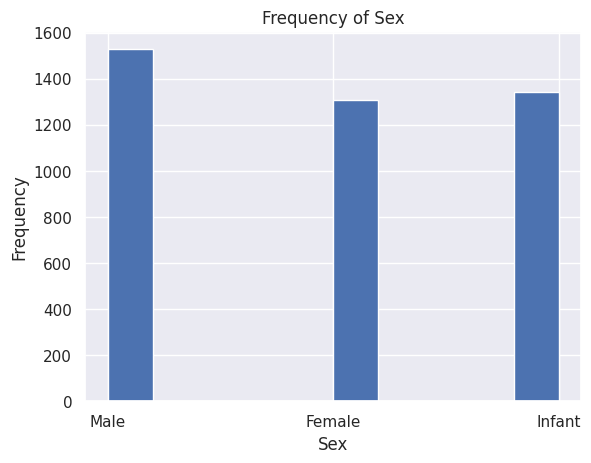

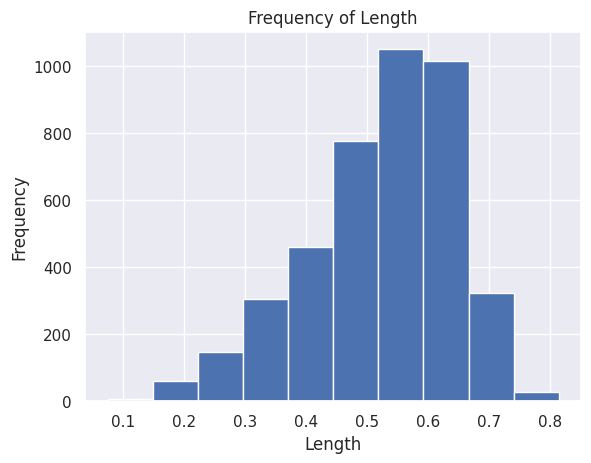

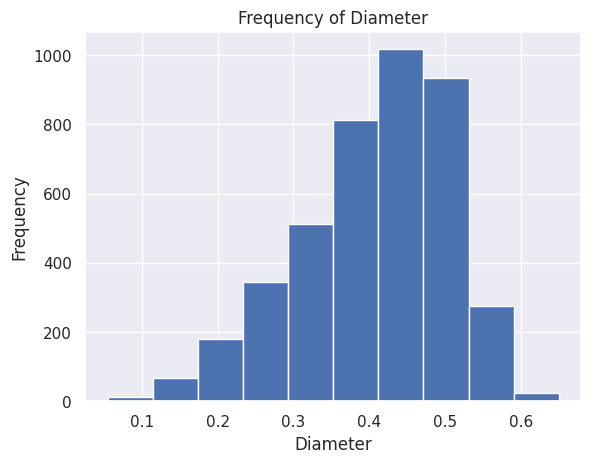

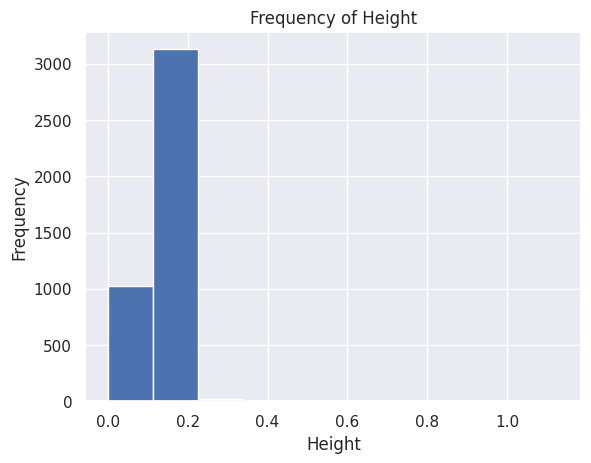

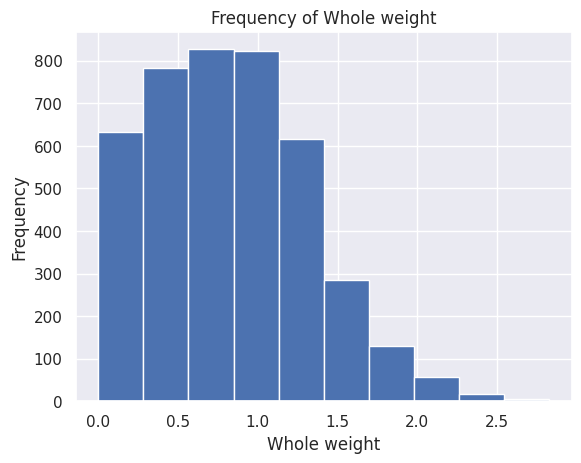

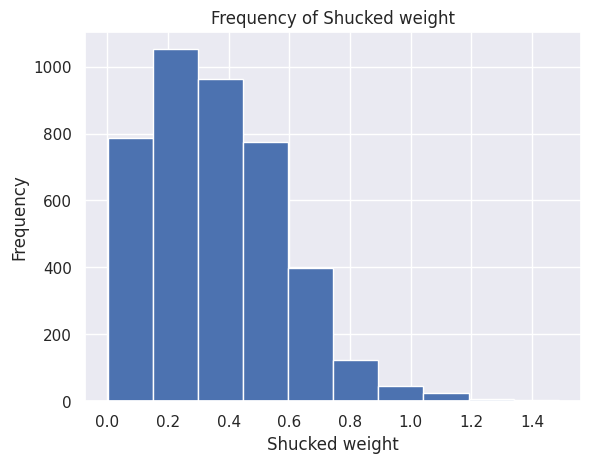

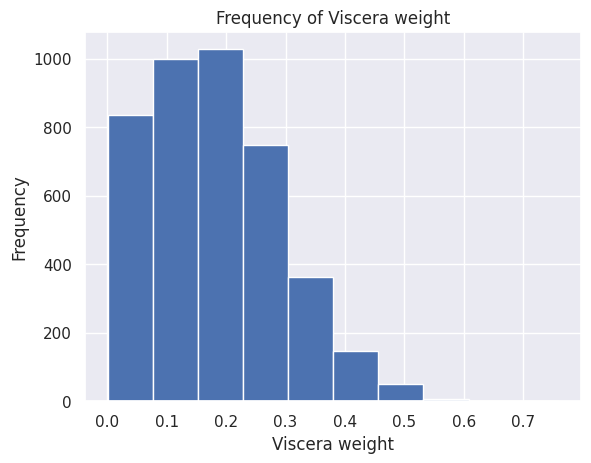

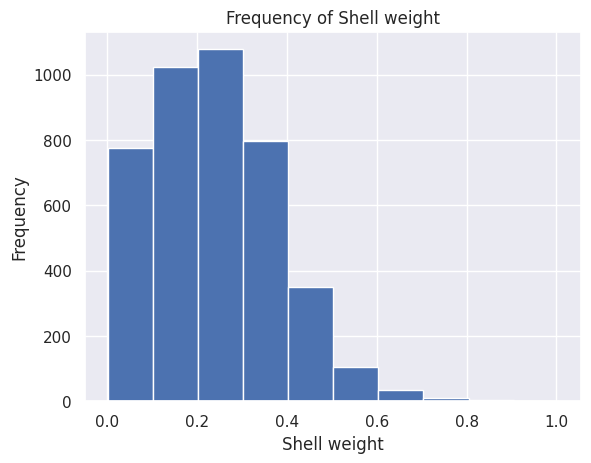

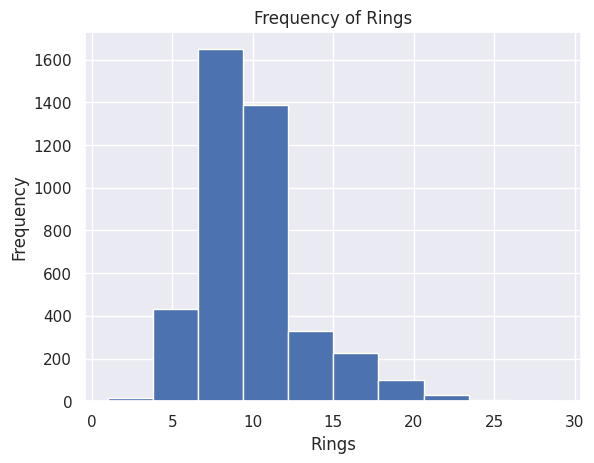

In [5]:
cols = abalone.columns
for col in cols:
  plt.figure()
  plt.hist(abalone[col])
  plt.title(f'Frequency of {col}')
  plt.xlabel(f'{col}')
  plt.ylabel('Frequency')

You can also use a density plot to get a better view of the data, but this visualization shows the same thing: many unimodal features.

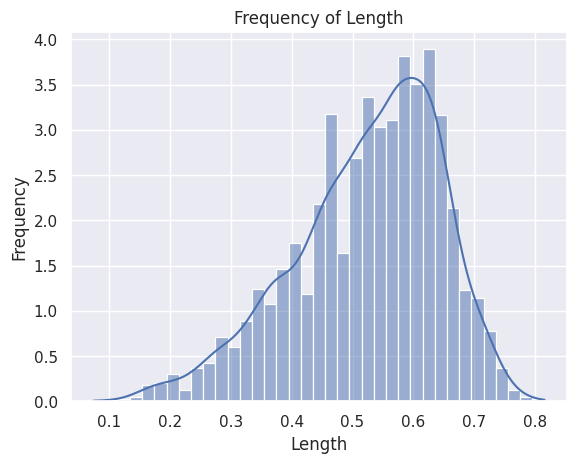

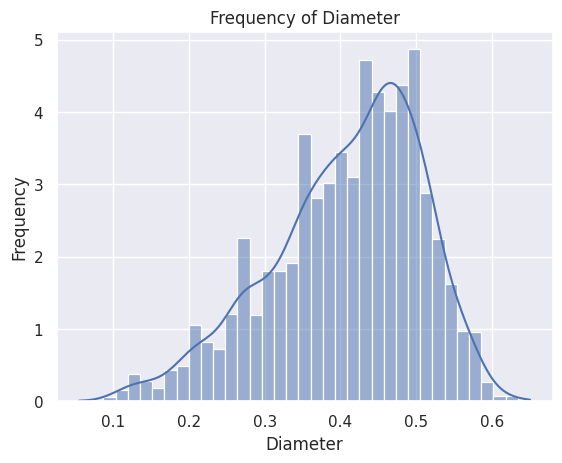

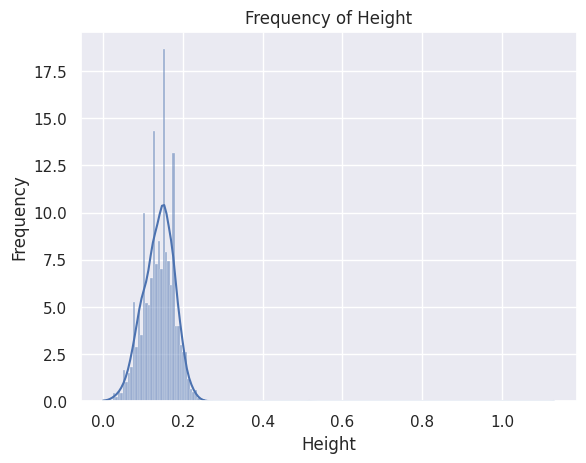

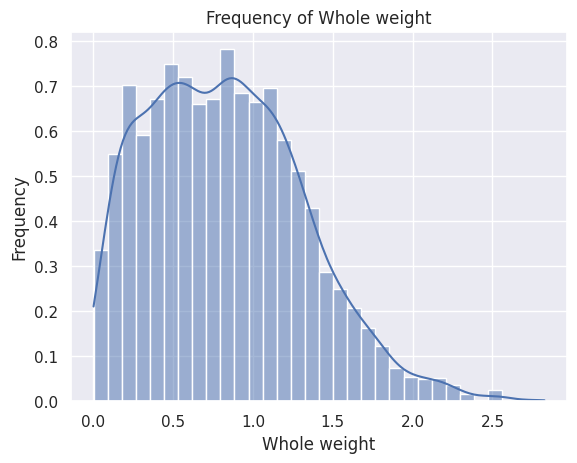

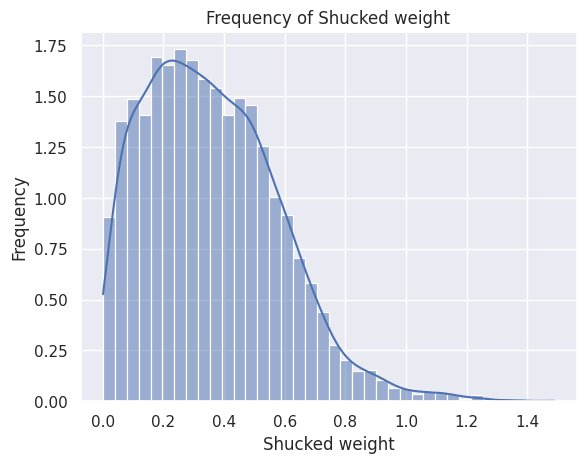

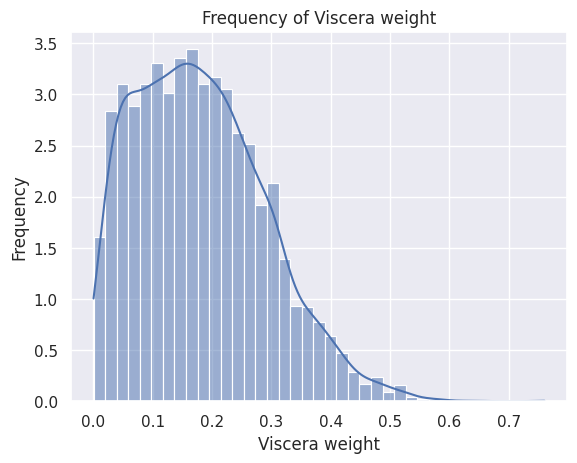

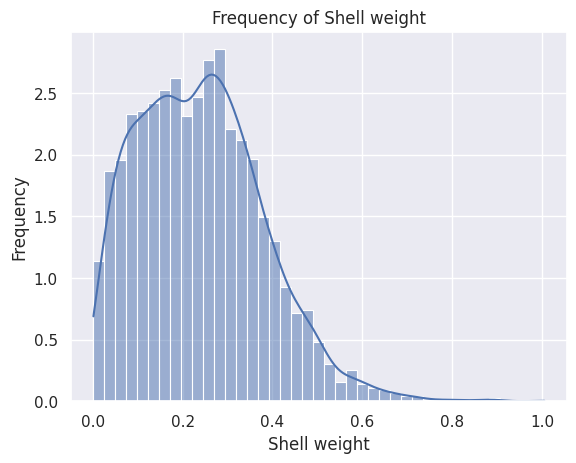

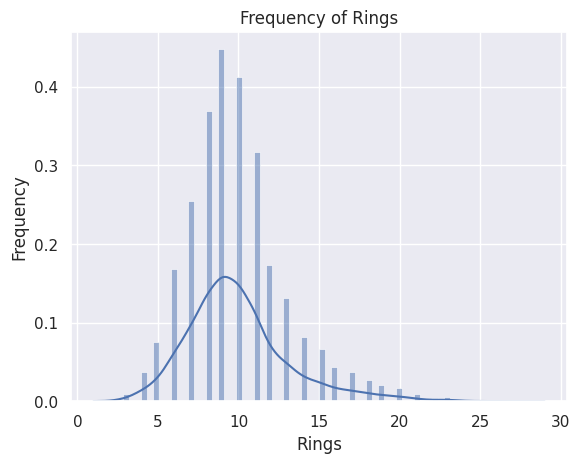

In [6]:
cols = cols[cols != 'Sex']
for col in cols:
  plt.figure()
  sns.histplot(abalone[col], kde = True, stat = 'density')
  plt.title(f'Frequency of {col}')
  plt.xlabel(f'{col}')
  plt.ylabel('Frequency')

## Identifying Clusters

With eight separate variables, there's plenty to look at here, but nearly any pair of variables appears to produce a visible correlation. The variable that seems to produce the least info when compared to others seems to be rings, which is rather unfortunate since the rings on an abalone shell (target variable) are the best way to determine the age of a specimen.  
Each of these makes pretty intuitive sense as well, since most of them are measurements of size, and they all appear to correlate positively with one another, whether linearly like length vs. height, logarithmically like length vs. whole weight, or exponentially like whole weight vs. diameter.

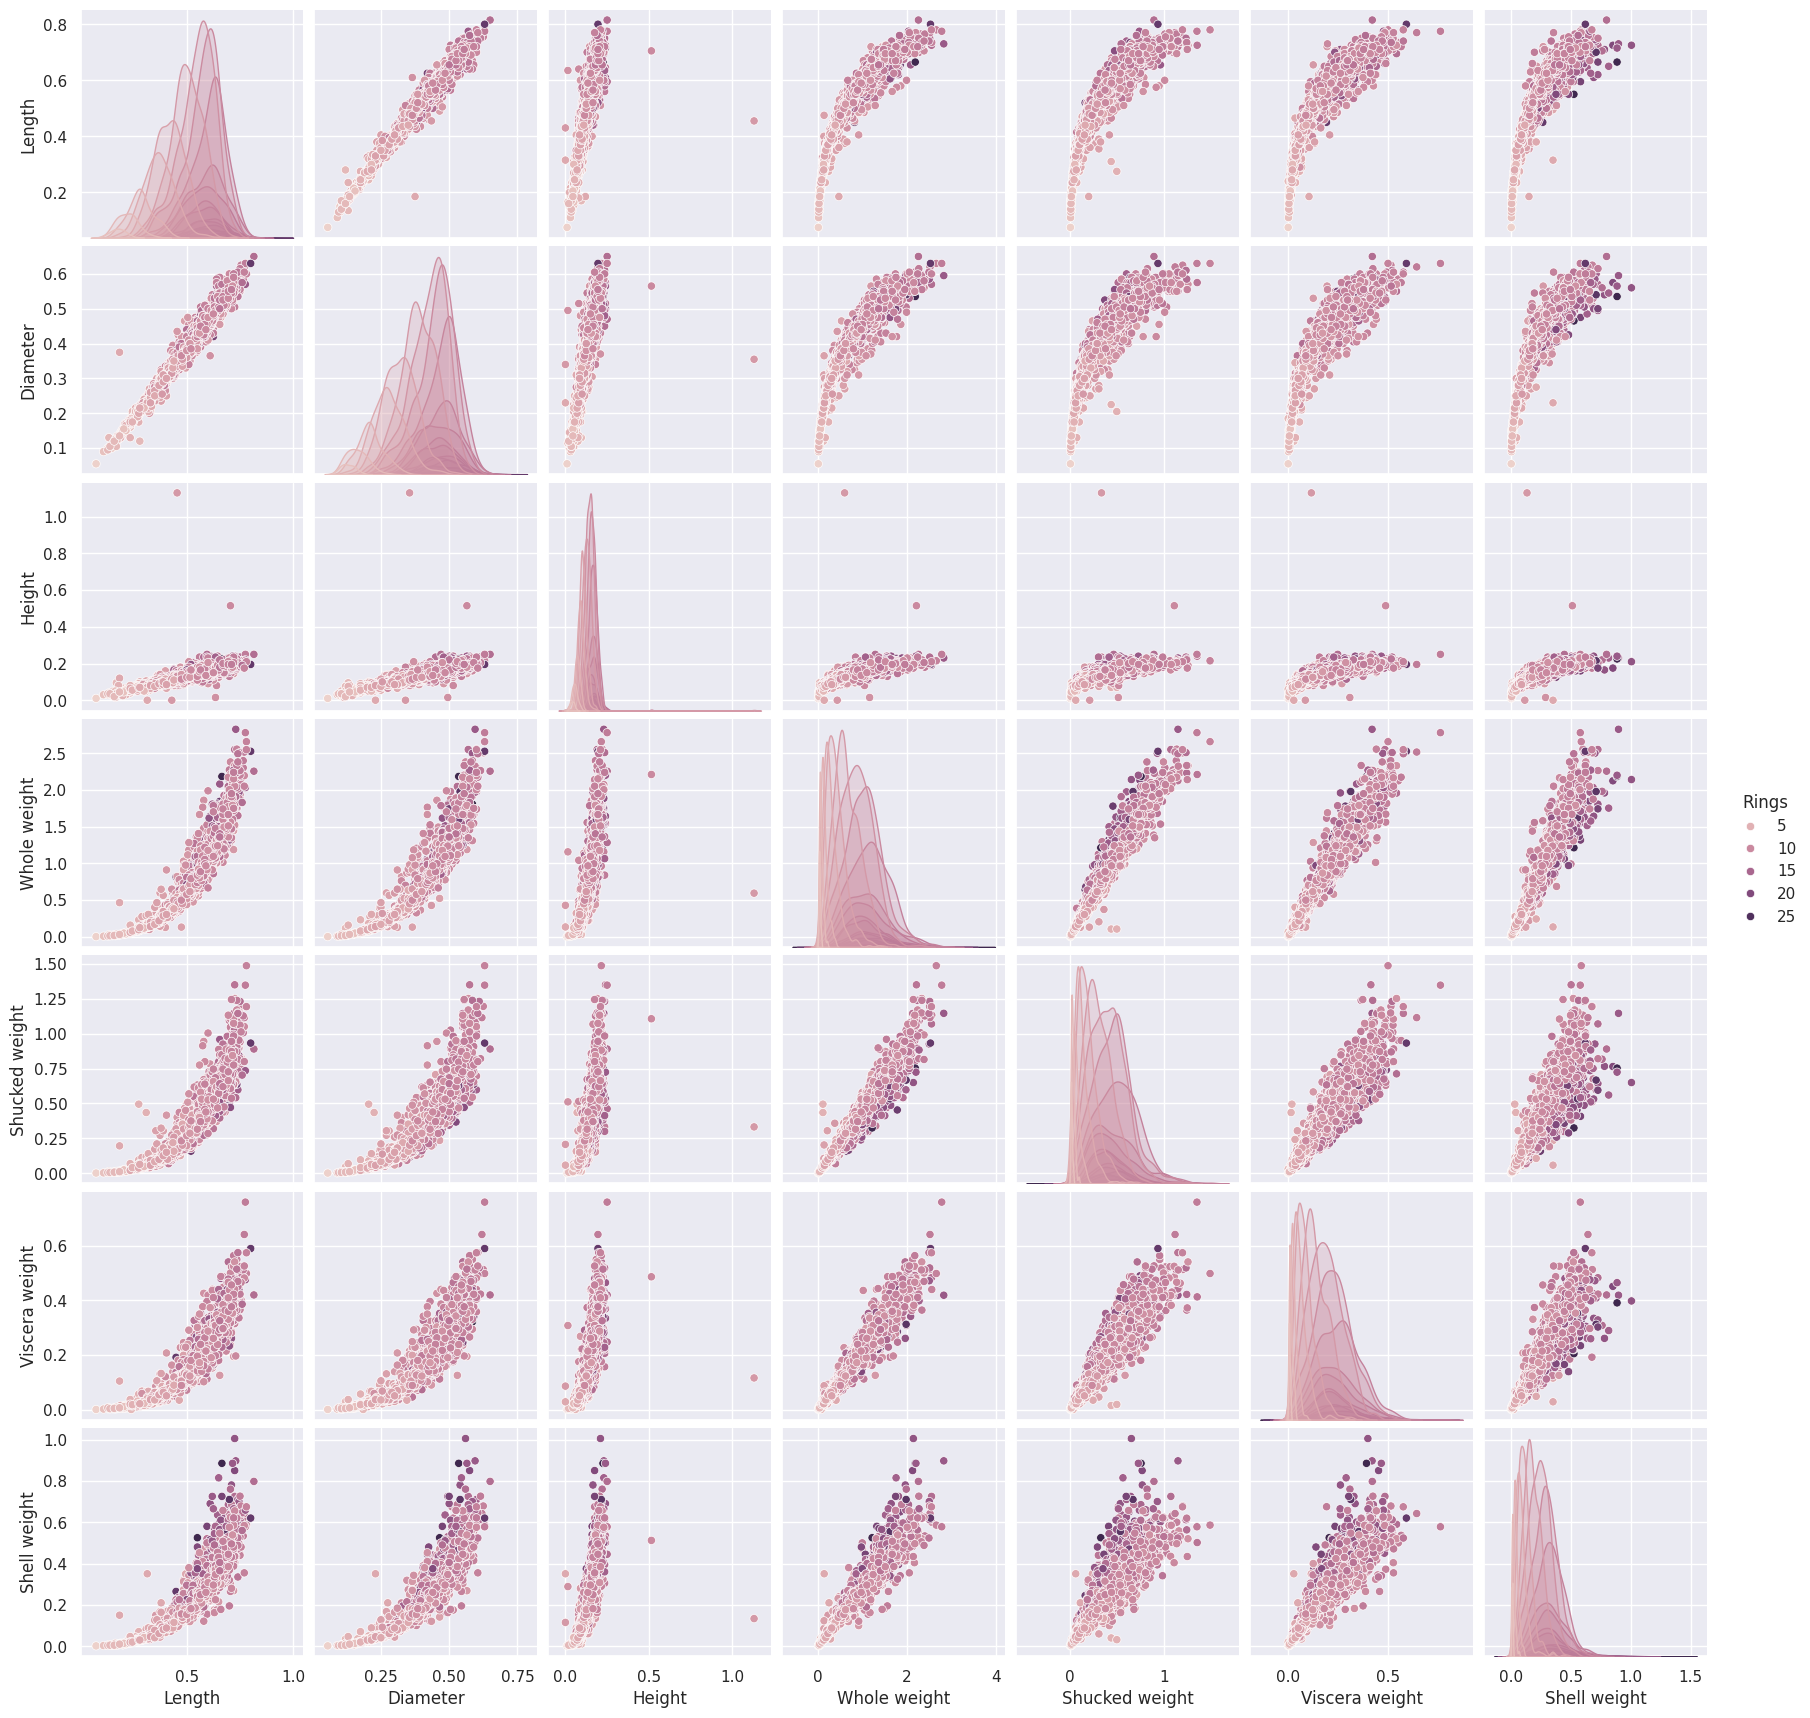

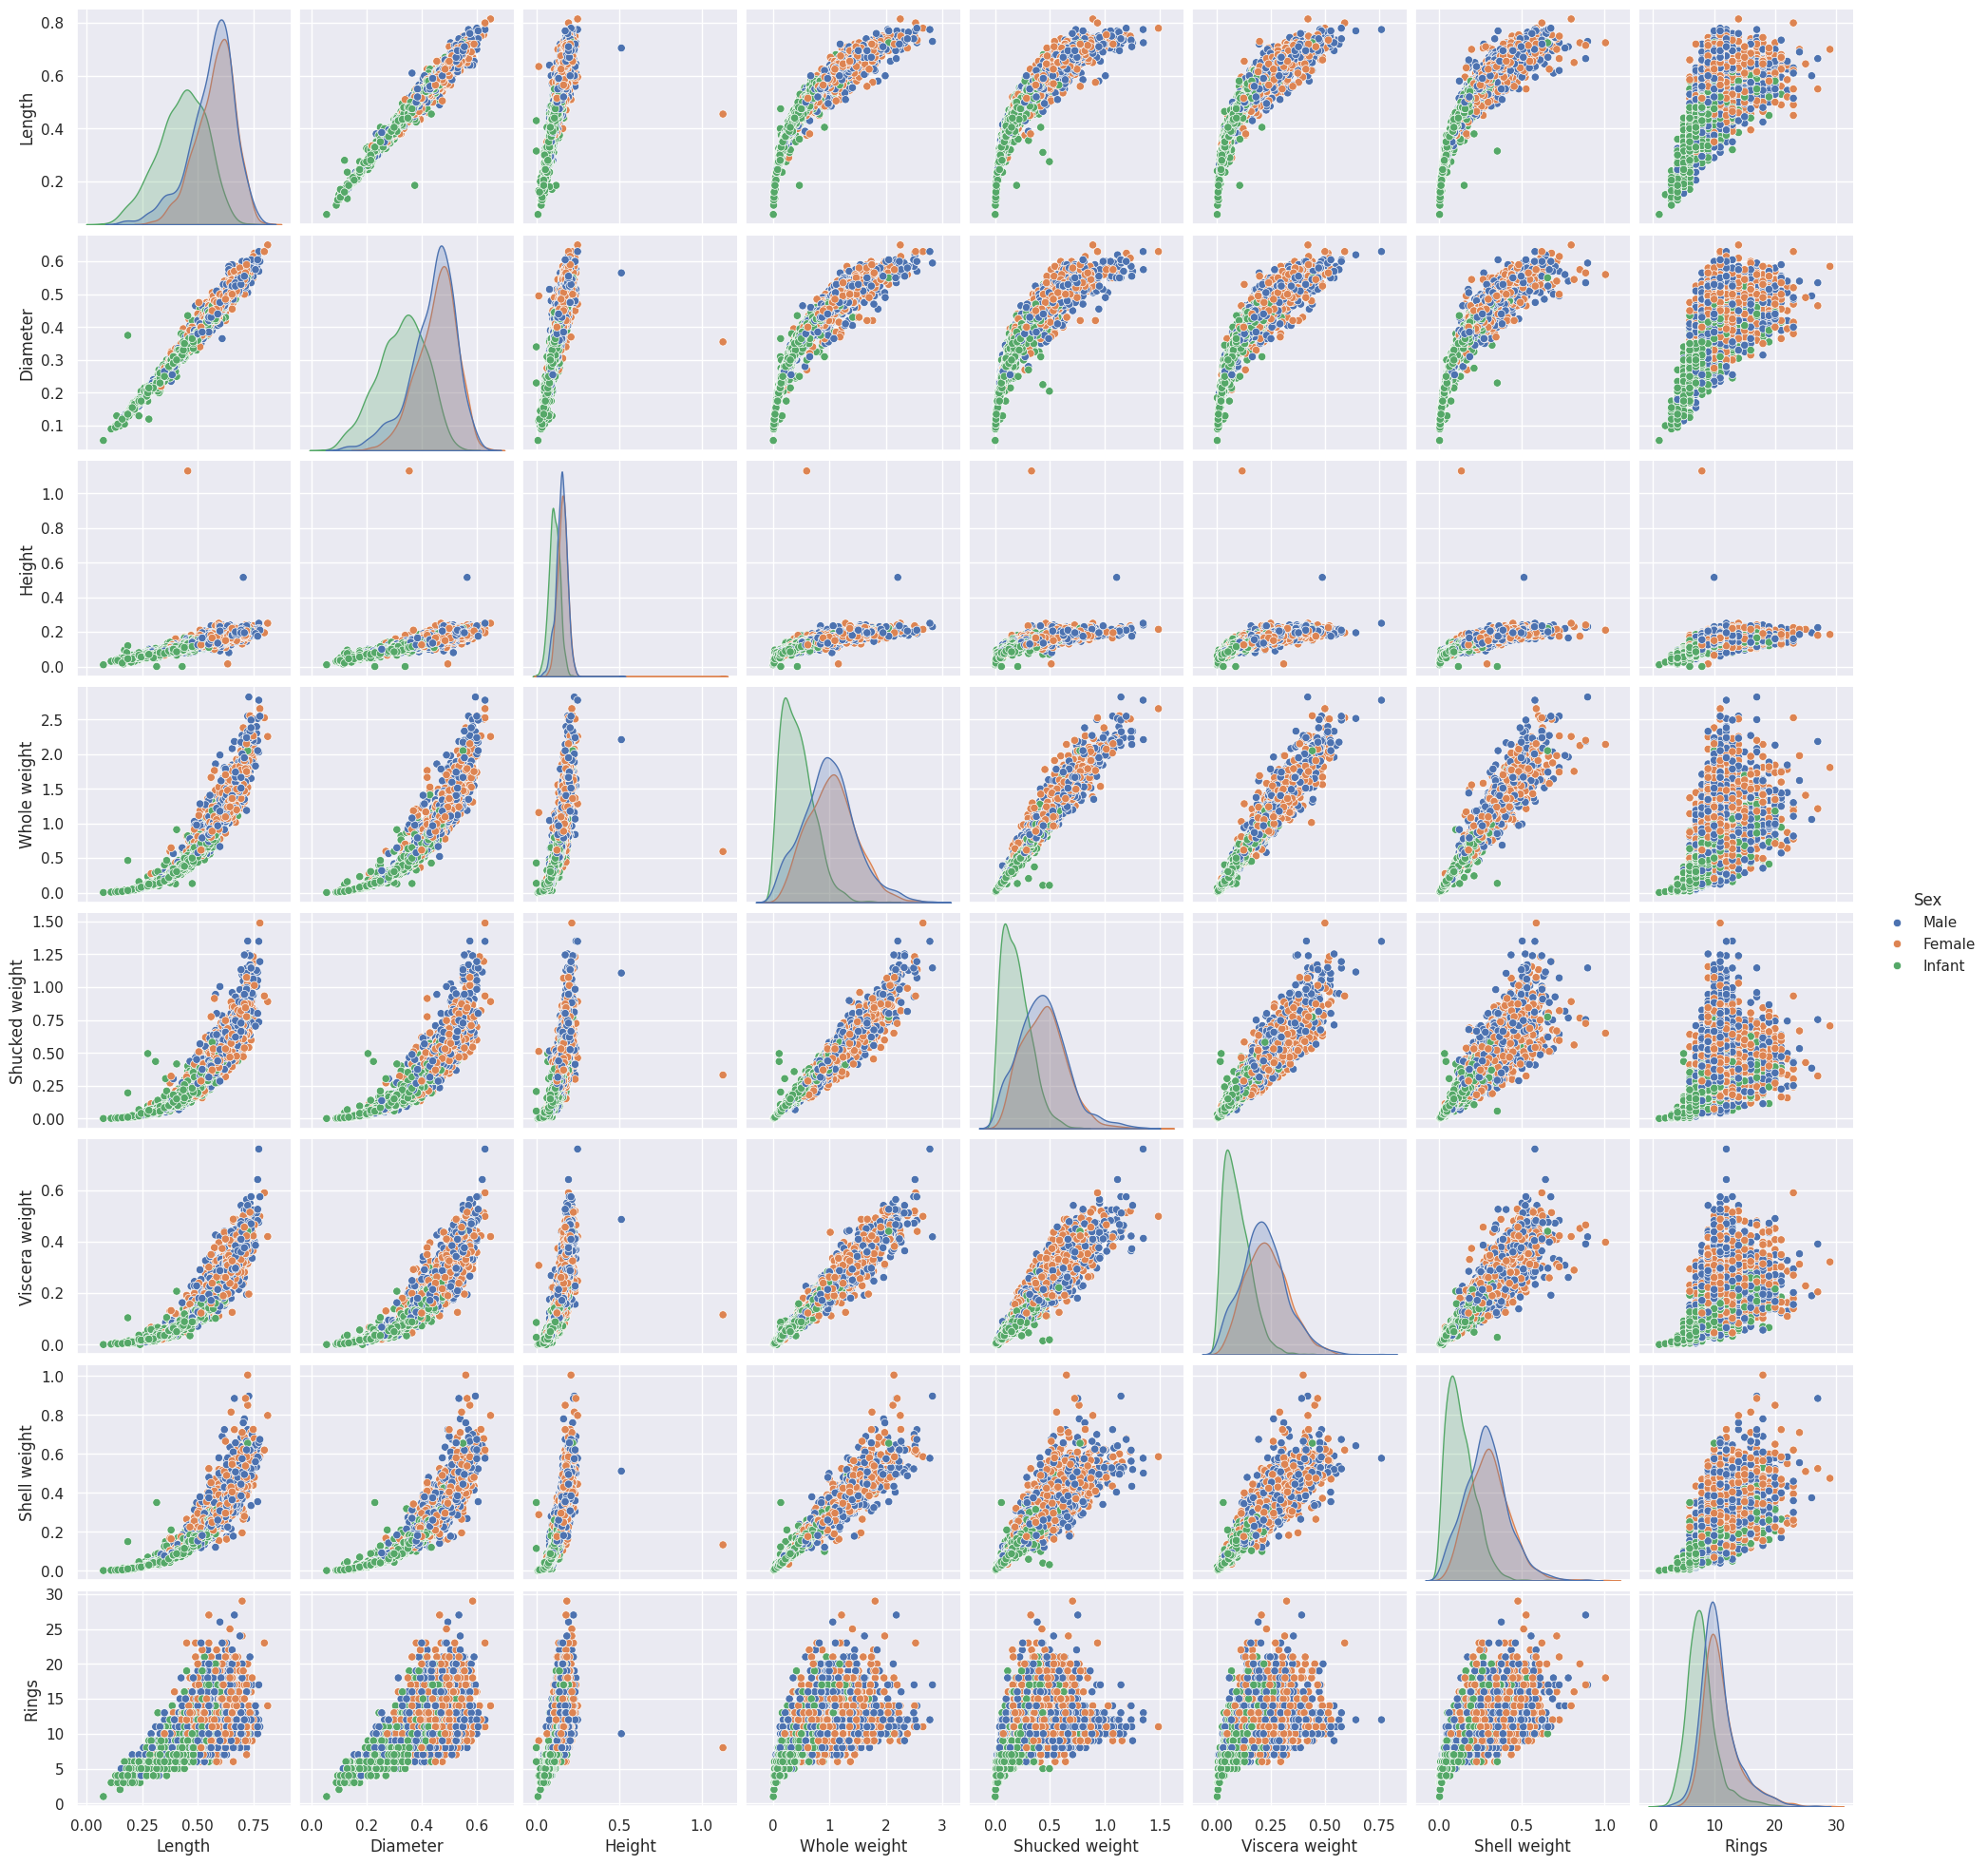

In [7]:
sns.pairplot(abalone, hue='Rings')
sns.pairplot(abalone, hue='Sex')

## Dependent Variable Representation

The representation of the dependent variable (rings) is clearly very lopsided. There are far more specimens with 7-11 rings, with less above or below that range. Since rings can be used to find the age of a specimen by adding ~1.5 to determine years, we can see that most of the specimens were between 8.5 and 12.5 years of age. This will likely lead to the first few decisions in the dtree determining whether a particular specimen fits into one of these bins, since lots of entropy can be reduced this way.

In [8]:
abalone['Rings'].unique()

array([15,  7,  9, 10,  8, 20, 16, 19, 14, 11, 12, 18, 13,  5,  4,  6, 21,
       17, 22,  1,  3, 26, 23, 29,  2, 27, 25, 24])

<Axes: xlabel='Rings', ylabel='count'>

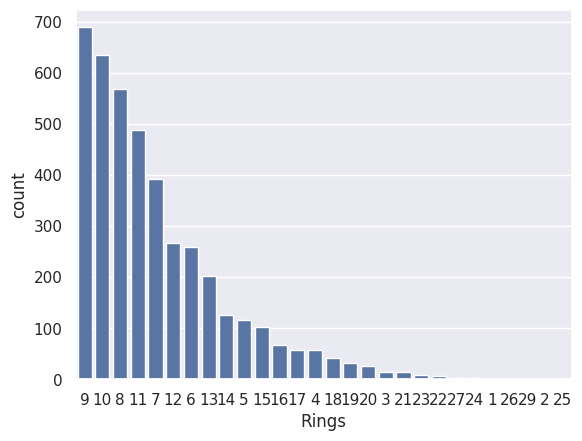

In [9]:
sns.countplot(x='Rings', data=abalone, order=abalone['Rings'].value_counts().index)

# Part II: Modeling

## Pre-processing

In [10]:
abalone.replace(['Male', 'Female', 'Infant'], [1, 2, 0], inplace=True)
abalone['Sex'] = abalone['Sex'].astype(int)
abalone.head()

Sex  Length  Diameter  Height  Whole weight  Shucked weight  \
0    1   0.455     0.365   0.095        0.5140          0.2245   
1    1   0.350     0.265   0.090        0.2255          0.0995   
2    2   0.530     0.420   0.135        0.6770          0.2565   
3    1   0.440     0.365   0.125        0.5160          0.2155   
4    0   0.330     0.255   0.080        0.2050          0.0895   

   Viscera weight  Shell weight  Rings  
0          0.1010         0.150     15  
1          0.0485         0.070      7  
2          0.1415         0.210      9  
3          0.1140         0.155     10  
4          0.0395         0.055      7

The features are all attributes except the rings, and all except sex are a measurement of size.

In [11]:
features = abalone.drop('Rings', axis = 1)
features.head()

Sex  Length  Diameter  Height  Whole weight  Shucked weight  \
0    1   0.455     0.365   0.095        0.5140          0.2245   
1    1   0.350     0.265   0.090        0.2255          0.0995   
2    2   0.530     0.420   0.135        0.6770          0.2565   
3    1   0.440     0.365   0.125        0.5160          0.2155   
4    0   0.330     0.255   0.080        0.2050          0.0895   

   Viscera weight  Shell weight  
0          0.1010         0.150  
1          0.0485         0.070  
2          0.1415         0.210  
3          0.1140         0.155  
4          0.0395         0.055

The target that we'd like to be able to determine (without dismembering specimens) is the number a rings, which is directly tied to the age of a specimen. We have specimens of every age from 1-29, except for exactly 28 years of age.

In [12]:
target = pd.DataFrame(abalone.Rings)
print(target.Rings.unique())
print(target.nunique())
target.head()

[15  7  9 10  8 20 16 19 14 11 12 18 13  5  4  6 21 17 22  1  3 26 23 29
  2 27 25 24]
Rings    28
dtype: int64


Rings
0     15
1      7
2      9
3     10
4      7

## Unrestricted Tree

In [13]:
dtree = tree.DecisionTreeClassifier(criterion = 'entropy')
dtree.fit(features, target)

DecisionTreeClassifier(criterion='entropy')

The unrestricted tree, of course, predicts its own training data with 100% accuracy, but only because we let it become grossly complex and go 21 decisions deep.

In [14]:
pred = dtree.predict(features)
accuracy = accuracy_score(target, pred)
print(f"Tree depth: {dtree.get_depth()}")
print(f"Accuracy: {accuracy}")

Tree depth: 21
Accuracy: 1.0


## 80% Accurate Tree

The first tree to reach 80% accuracy only needed to go 13 decisions deep. This is still fairly complex, but it's about a 1/3 reduction from the original model.

In [15]:
depth = 1
sufficient_accuracy = False
while not sufficient_accuracy:
  simple_tree = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = depth)
  simple_tree.fit(features, target)
  pred = simple_tree.predict(features)
  accuracy = accuracy_score(target, pred)
  if accuracy >= 0.8:
    sufficient_accuracy = True
  else:
    depth += 1
  print(depth, accuracy)

2 0.2121139573856835
3 0.2532918362461096
4 0.26645918123054824
5 0.2829782140292076
6 0.2966243715585348
7 0.31505865453674886
8 0.3466602824994015
9 0.38951400526693797
10 0.4625329183624611
11 0.5453674886282021
12 0.6502274359588222
13 0.7524539142925545
13 0.8403160162796265


## Major Trends

In [16]:
print(dtree.get_params())
print(simple_tree.get_params())

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 13, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}


The major trends between the two models are essentially the same, as one can see that the first few layers of decisions in both models are essentially identical. This makes perfect sense, since both trees were built with the 'entropy' criterion, and the max allowable depth of the tree will not have any effect on using entropy to calculate how to separate at each step (it's a top down process).  
A different result may come from another criterion, but trees using the default criterion (gini) led to depths of 30 and 15 decisions for the unlimited and simple model, respectively, so I went with the less complex criterion.  
  
These major trends look to be related primarily with shell weight (involved in every one of the first four layers of decisions), along with whole weight and shucked weight, each of which appear more than once. Also important are diameter and sex. It makes perfect sense that the 'size' variables of diameter and various weights are important in determining the number of rings on a specimen, since rings are a proxy for age, and things grow as they age.  
  
The importance of sex in the process also makes sense when you consider that in this particular dataset, 'infant' is a label for those specimens that are too young to be able to reliably label as male or female. Therefore a 'sex' of 0 (stand-in value for 'infant') means a young specimen, and 1 or 2 for male or female means an older specimen, so again it makes sense that this is important within the tree.

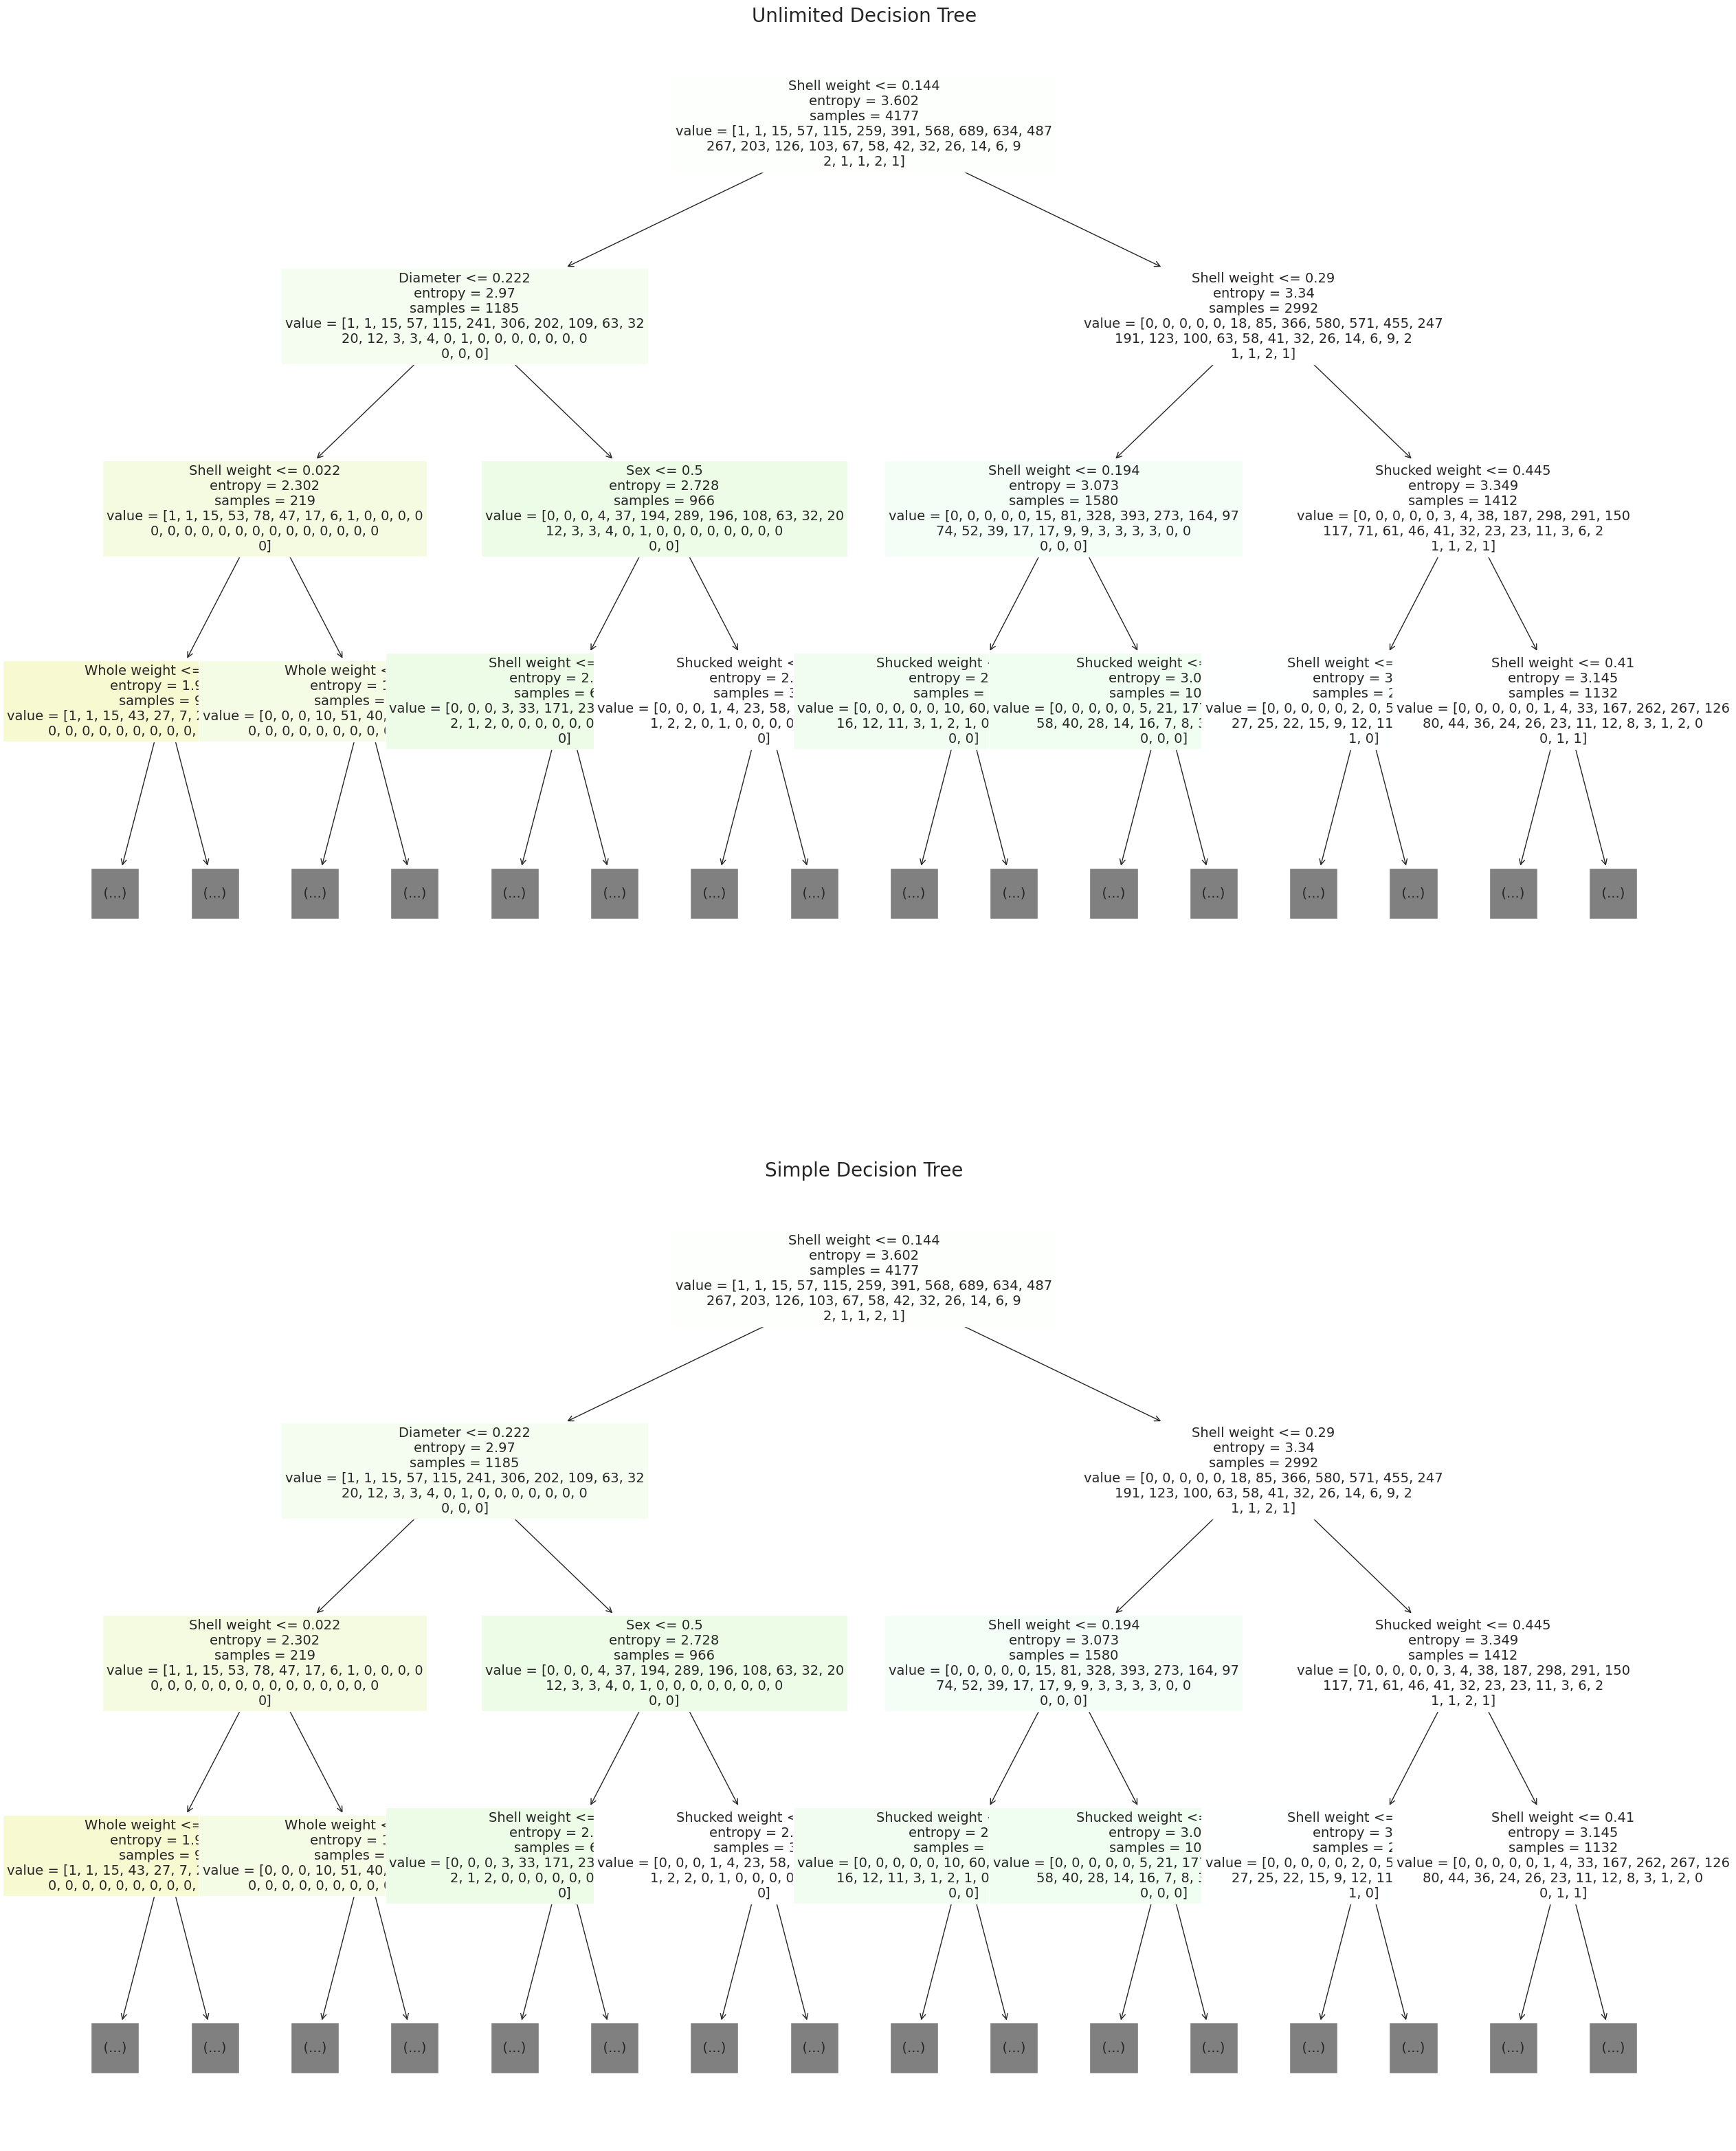

In [17]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize = (30, 40))

tree.plot_tree(dtree, feature_names = features.columns, filled = True, max_depth = 3, fontsize = 14, ax = axes[0])
tree.plot_tree(simple_tree, feature_names = features.columns, filled = True, max_depth = 3, fontsize = 14, ax = axes[1])
axes[0].set_title('Unlimited Decision Tree', fontsize = 20)
axes[1].set_title('Simple Decision Tree', fontsize = 20)

plt.show()

## Scatter Plot Clustering

The trends visible in the tree visualizations are fairly easy to see in a scatter plot of the most relevant variables.  Every one of the most 'size' variables is positively correlated with each of the others. Even the categorical 'sex' variable shows a visible difference between 0 (infant) and 1 or 2 (male or female), where non-infant specimens are clearly associated with larger measurements.  
Additionally, within each scatter plot you can see that the 'higher' up the combined trend you go, the darker the data points become, indicating more rings on these specimens. Interestingly, you can also see which of the two variables is 'more important', by seeing which side of the distribution has darker points. For example, the row of comparisons between 'shell weight' and other variables quite clearly shows darker points increasing faster along the y-direction (shell weight direction). This fits with our decision tree, which has at least one decision based on shell weight in every one of the first four layers of decisions.

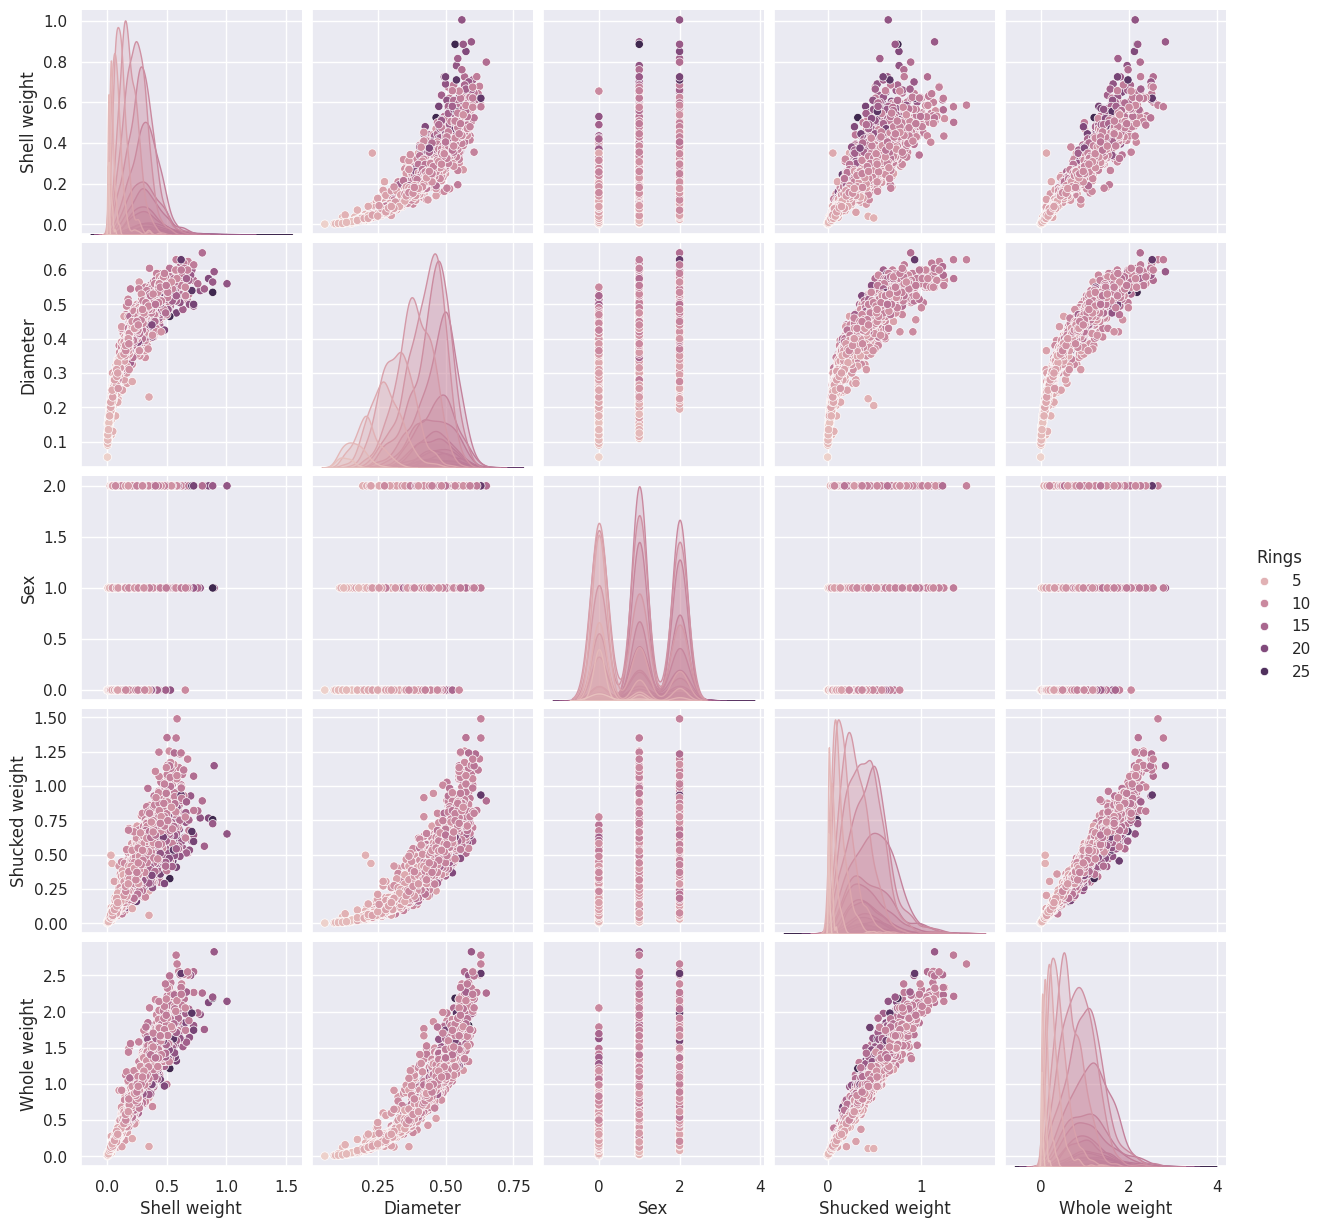

In [18]:
sns.pairplot(abalone, vars = ['Shell weight', 'Diameter', 'Sex', 'Shucked weight', 'Whole weight'], hue = 'Rings')